<div class="alert alert-block alert-success">
<b>NOTEBOOK 1 - Data Structural Cleanup
</div>

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

Make sure to check `README.md` and `requirements.txt` before running any notebooks. 

In [151]:
# Import modules
import sys
import pickle
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from math import floor

### 1.2 - DEFINE PATHS

In [152]:
# Paths
PROJECT_PATH = Path.cwd().resolve().parent
DATA_PATH = PROJECT_PATH / "data"
RAW_DATA_PATH = DATA_PATH / "raw"
META_PATH = DATA_PATH / "meta"
INTERIM_DATA_PATH = DATA_PATH / "interim"
SRC_PATH = PROJECT_PATH / "src"
UTILS_PATH = SRC_PATH / "utilities"

# Add src to sys.path (for package-style imports)
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

# Add utilities folder to sys.path (for direct import utils)
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))


# Import with reload
try:
    import utilities.utils as utils
except ModuleNotFoundError:
    import utils

reimport = importlib.reload(utils)

### 1.3 - LOAD DATASET

In [153]:
# Load Data
file_path = INTERIM_DATA_PATH / "01_climate_dataset_filtered.xlsx"
df = pd.read_excel(file_path, sheet_name=None)["Sheet1"]

---
# 2 - STRUCTURAL CLEANUP

### 2.1 - DROP DUPLICATES

In [154]:
# Drop duplicates / administrative columns (adjust if needed)
drop_candidates = [
    "record",
    "uuid",
    "language",
    "sd2",
    "origage",
    "mpq",
    "mpq2",
    "qc1",
    "qc2",
    "qc3",
    "sd8recode",
    "sd6",
    "SD8_dupe1",
    "Weight in the country"
]

# Keep only relevant Likert columns
filtered_cols = [
    col for col in df.columns
    if col not in drop_candidates
]

# Create the cleaned dataset
likert_cleaned_df = df[filtered_cols]

# Show the shape and column names
print("Cleaned dataset shape:", likert_cleaned_df.shape)
print("Columns kept:", filtered_cols)

# Save current dataset to file
filename = "02_climate_dataset_filtered_raw.xlsx"
utils.save_dataset(likert_cleaned_df, "02_climate_dataset_condensed.xlsx", "interim")

Cleaned dataset shape: (1008, 78)
Columns kept: ['sd8', 'agerecode', 'sd1', 'sd3', 'occupation', 'sd4it', 'sd5it', 'sd6b', 'SD8recode_dupe1', 'Q1_2024r1', 'Q1_2024r13', 'Q1_2024r14', 'Q1_2024r3', 'Q1_2024r4', 'Q1_2024r15', 'Q1_2024r5', 'Q1_2024r6', 'Q1_2024r7', 'Q1_2024r8', 'Q1_2024r9', 'Q1_2024r10', 'Q1_2024r11', 'Q1_2024r12', 'q2_dupe1', 'q3_dupe1', 'q4r1', 'q4r2', 'q5r1', 'q5r2', 'q5r3', 'q5r4', 'q5r5', 'q5r6', 'q5r7', 'q5r8', 'q5r9', 'q6r1', 'q6r2', 'q6r3', 'q6r4', 'q6r5', 'q6r6', 'q6r7', 'q6r8', 'q6r9', 'q6r10', 'q6r11', 'q7_dupe1', 'q8_dupe1', 'q9_dupe1', 'q10r1_dupe1', 'q10r2_dupe1', 'q11_dupe1', 'q12r1', 'q12r2', 'q12r3', 'q12r4', 'q12r5', 'q12r6', 'q12r7', 'q12r8', 'q12r9', 'q13r1', 'q13r2', 'q13r3', 'q13r4', 'q13r5', 'q13r6', 'q13r7', 'q13r8', 'q14', 'q15', 'q16_dupe1', 'q18_dupe1', 'q19_dupe1', 'q20_dupe1', 'q21', 'q22']
File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clusterin

### 2.2 - RENAME FEATURES

In [155]:
# Copy of your cleaned dataset
condensed_df = likert_cleaned_df.copy()

# Rename demographic variables
rename_map = {
    "sd1": "gender",
    "sd8": "kids",
    "agerecode": "age_group",
    "sd4it": "region",
    "sd5it": "net_income",
    "sd6b": "political_preference",
    "SD8recode_dupe1": "education",
    "q18_dupe1": "domestic_responsibility",
    "q19_dupe1": "global_solidarity",
    "q20_dupe1": "housing_status",
    "q22": "living_area"
}

for old, new in rename_map.items():
    if old in condensed_df.columns:
        condensed_df.rename(columns={old: new}, inplace=True)
        
condensed_df
#Check political preference values
print(condensed_df["political_preference"].value_counts(dropna=False))
# Check missing values  in political preference   
print(condensed_df["political_preference"].isnull().sum())


political_preference
5.0     184
6.0     122
8.0     103
3.0     101
7.0      84
4.0      78
11.0     71
2.0      60
1.0      56
9.0      54
10.0     53
NaN      42
Name: count, dtype: int64
42


### 2.3 - FEATURE ENGINEERING

In [156]:
# Create meaningful features

# Group Q1 (national concerns)
condensed_df["environmental_concerns"] = condensed_df[["Q1_2024r4", "Q1_2024r10"]].sum(axis=1)

# Recode Q2 and Q3 into engagement score
if "q2_dupe1" in condensed_df.columns:
    condensed_df["proactiveness"] = condensed_df["q2_dupe1"].replace({1: 2, 2: 1, 3: 2, 4: 0})
if "q3_dupe1" in condensed_df.columns:
    condensed_df["adaptation_importance"] = condensed_df["q3_dupe1"].replace({1: 2, 2: 1, 3: 0})
condensed_df["adaptation_engagement_score"] = (
    condensed_df["proactiveness"] + condensed_df["adaptation_importance"]
)

# Q5 – Climate event experiences
condensed_df["heat_experience"] = condensed_df[["q5r1", "q5r2", "q5r4"]].sum(axis=1)
condensed_df["flood_experience"] = condensed_df[["q5r7", "q5r8"]].sum(axis=1)
condensed_df["climate_event_count"] = condensed_df[[f"q5r{i}" for i in range(1, 9)]].sum(axis=1)

# Q6 – Consequences from climate
condensed_df["infra_consequences"] = condensed_df[["q6r1", "q6r6", "q6r8"]].sum(axis=1)
condensed_df["health_consequences"] = condensed_df[["q6r5"]].sum(axis=1)
condensed_df["climate_consequence_count"] = condensed_df[[f"q6r{i}" for i in range(1, 11)]].sum(axis=1)

# Q7 and Q14 – Emotional + home concern (reverse coded)
if "q7_dupe1" in condensed_df.columns:
    condensed_df["emotional_concern"] = condensed_df["q7_dupe1"].replace({1: 4, 2: 3, 3: 2, 4: 1})
if "q14" in condensed_df.columns:
    condensed_df["home_concern"] = condensed_df["q14"].replace({1: 4, 2: 3, 3: 2, 4: 1})
condensed_df["climate_concern"] = (
    condensed_df["emotional_concern"] + condensed_df["home_concern"]
)

# Q15 + Q16 – Personal preparedness
if "q15" in condensed_df.columns and "q16_dupe1" in condensed_df.columns:
    condensed_df["personal_preparedness_score"] = (condensed_df["q15"] + condensed_df["q16_dupe1"])

# Remap Gender – 1 -> 0, 2 -> 1
condensed_df["gender"] = condensed_df["gender"].map({1: 0, 2: 1})

# Final selected columns (you can use this list for modeling/clustering)
selected_features = [
    "environmental_concerns",
    "adaptation_engagement_score",
    "climate_event_count",
    "flood_experience",
    "heat_experience",
    "climate_consequence_count",
    "infra_consequences",
    "health_consequences",
    "climate_concern",
    "personal_preparedness_score",
    "domestic_responsibility",
    "global_solidarity",
    "gender", "age_group", "kids", "education", "net_income",
    "political_preference", "housing_status", "living_area"
]

# Drop unnecessary columns
columns_to_drop = (
    ["q2_dupe1", "q3_dupe1", "q14", "q15", "q16_dupe1", "q18_dupe1", "q19_dupe1", "q7_dupe1"] +
    [f"Q1_2024r{i}" for i in range(1, 16)] +
    [f"q5r{i}" for i in range(1, 10)] +
    [f"q6r{i}" for i in range(1, 12)]
)

condensed_df.drop(columns=[col for col in columns_to_drop if col in condensed_df.columns], inplace=True)

# Final check
condensed_df = condensed_df[[col for col in selected_features if col in condensed_df.columns]]
features = condensed_df.columns
print(features)

# Save
utils.save_dataset(condensed_df, "03_climate_dataset_quality_check_ready.xlsx", "interim")

Index(['environmental_concerns', 'adaptation_engagement_score',
       'climate_event_count', 'flood_experience', 'heat_experience',
       'climate_consequence_count', 'infra_consequences',
       'health_consequences', 'climate_concern', 'personal_preparedness_score',
       'domestic_responsibility', 'global_solidarity', 'gender', 'age_group',
       'kids', 'education', 'net_income', 'political_preference',
       'housing_status', 'living_area'],
      dtype='object')
File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\interim\03_climate_dataset_quality_check_ready.xlsx


In [157]:
print(condensed_df.shape)
display(condensed_df)    

(1008, 20)


,environmental_concerns,adaptation_engagement_score,climate_event_count,flood_experience,heat_experience,climate_consequence_count,infra_consequences,health_consequences,climate_concern,personal_preparedness_score,domestic_responsibility,global_solidarity,gender,age_group,kids,education,net_income,political_preference,housing_status,living_area
0,1,4,0,0,0,0,0,0,5,3,3,2,0,5,2,2,10,7.0,2,1
1,1,4,1,0,0,1,0,0,6,4,2,3,0,5,2,3,1,6.0,1,2
2,0,4,2,0,2,0,0,0,5,5,5,3,1,3,2,2,1,10.0,2,3
3,0,3,3,1,1,0,0,0,4,5,1,3,0,3,2,3,11,5.0,2,2
4,0,3,1,0,1,3,1,1,6,3,3,2,1,3,2,3,9,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0,3,3,1,1,0,0,0,4,3,1,3,0,4,2,3,10,8.0,2,1
1004,0,2,4,0,3,1,0,0,4,3,5,4,1,5,2,1,2,8.0,2,2
1005,1,3,1,0,1,2,0,1,7,3,2,1,1,5,2,3,10,2.0,2,1
1006,0,4,3,0,3,1,1,0,7,2,3,2,0,3,1,3,10,9.0,2,1


### 2.4 - FEATURE TYPING ATTRIBUTION

**Feature Typing**
I ended up with 20 usable features for my clustering project which I then divided into two groups:

>- Ordinal/Likert-based composites (psychographic and attitudinal features treated as numeric) - what clustering should capture. I framed the project around awareness, responsibility, preparedness, experiences. Those are attitudinal/behavioral dimensions. The clusters should emerge from what people think and do about climate change.

>- Categorical (nominal / ordinal demographics post-hoc) - what should help interpret clustering. Gender, age, education, income, political leaning… those are descriptors of who people are. Mixing them directly in clustering would mean that the algorithm might group people just because they share demographic categories, not because they have distinct climate attitudes. So they will be used to profile and label the clusters. 
Example: if I included them in clustering, I would risk ending up with a “mostly male” cluster that doesn’t tell me anything new about climate awareness or I would let the algorithm carve out groups that are maybe partly defined by politics.

**Ordinal / Likert-based composites (treated as numeric):**
- `environmental_concerns`  
- `adaptation_engagement_score`  
- `climate_event_count`  
- `flood_experience`  
- `heat_experience`  
- `climate_consequence_count`  
- `infra_consequences`  
- `health_consequences`  
- `climate_concern`  
- `personal_preparedness_score`  
- `domestic_responsibility`  
- `global_solidarity`  

**Categorical (nominal / ordinal demographics):**
- `gender` (binary recoded)  
- `age_group` (ordinal categories)  
- `kids` (binary or small ordinal)  
- `education` (ordinal categories)  
- `net_income` (ordinal brackets → categorical with ordering)  
- `political_preference` (categorical, ordered if on left–right scale)  
- `housing_status` (categorical, unordered)  
- `living_area` (categorical / ordinal: urban, rural, etc.)  

So my strategy would be the following:
>- 1. Build clusters only on climate-related features and get groups defined by awareness, concern, responsibility, preparedness, experiences...
>- 2. Then, describe each cluster demographics and check whether they drive certain clusters or not. For each cluster, you calculate distributions like % left-leaning, % centrist, % right-leaning, % low vs. high education, median age, etc.
>- 3. Interpretation of results.

In [158]:
# Features intended for clustering (climate-related composites)
CLUSTER_FEATURES = [
    "environmental_concerns",
    "adaptation_engagement_score",
    "climate_event_count",
    "flood_experience",
    "heat_experience",
    "climate_consequence_count",
    "infra_consequences",
    "health_consequences",
    "climate_concern",
    "personal_preparedness_score",
    "domestic_responsibility",
    "global_solidarity",
]

# Demographics used for post-hoc interpretation (not for cluster formation)
DESCRIPTIVE_FEATURES = [
    "gender", "age_group", "kids", "education", "net_income",
    "political_preference", "housing_status", "living_area"
]

# Dataset with cluster features
cluster_df = condensed_df[CLUSTER_FEATURES].copy()  

# Dataset with descriptive features
desc_df = condensed_df[DESCRIPTIVE_FEATURES].copy()

### 2.5 - DATA ADEQUACY ASSESSMENT

**Data Adequacy Checks for Clustering**

This sections runs a compact, professional set of diagnostics to confirm whether the dataset is suitable for clustering.

What is covered:
1. **Sample Size Adequacy**
2. **Variability** (Coefficient of Variation of numeric features)
3. **Redundancy** (Correlation matrix)  
4. **Missingness Handling** (`political_preference`)
5. **Cluster Tendency** (Hopkins statistic)
6. **Actionable suggestions** automatically derived from results

> **Scope**: Use the ~12 climate composites for clustering; reserve demographics for post-hoc interpretation.

In [159]:
# Thresholds
LOW_CV = 0.10      # below → low variability
HIGH_CV = 2.00     # above → very high variability
HIGH_CORR = 0.90   # absolute correlation threshold to flag redundancy
HOPKINS_SAMPLE_RATIO = 0.10  # fraction of rows used in the test

**Sample Size Adequacy**

**Goal:** Check whether the dataset has enough observations to support stable clustering.  
**Rule of thumb:** At least **50–100 observations per cluster** expected.  
- With ~20 features, more rows are needed to avoid the curse of dimensionality.  
- If you expect 4–6 clusters, aim for **≥ 200–600 respondents** minimum.  

In [160]:
# Expected number of clusters (tweak as needed)
expected_clusters = 6  # try also 5 or 6

n_obs, n_features = cluster_df.shape

min_needed_low = expected_clusters * 50
min_needed_high = expected_clusters * 100

print(f"Dataset observations: {n_obs}")
print(f"Features (numeric composites): {n_features}")
print(f"Guideline sample size needed for {expected_clusters} clusters:")
print(f" - Lower bound (50 per cluster): {min_needed_low}")
print(f" - Upper bound (100 per cluster): {min_needed_high}")

if n_obs < min_needed_low:
    print("⚠️ Dataset may be underpowered for stable clustering.")
elif n_obs < min_needed_high:
    print("⚠️ Dataset meets minimum size but is on the lower edge. Interpret clusters cautiously.")
else:
    print("✅ Dataset size looks adequate for expected cluster count.")

Dataset observations: 1008
Features (numeric composites): 12
Guideline sample size needed for 6 clusters:
 - Lower bound (50 per cluster): 300
 - Upper bound (100 per cluster): 600
✅ Dataset size looks adequate for expected cluster count.


**Variability Assessment for numeric variables (Coefficient of Variation)**

**Goal:** Ensure features carry enough variation to form meaningful clusters.  
**Metric:** CV = std / mean

Guidelines:
- CV < 0.10 → low variability (weak contributor)
- CV > 2.0  → very high variability (consider transform/outlier handling)

In [161]:
desc = cluster_df.describe().T
display(desc)
cv = (desc['std'] / desc['mean']).rename("cv")
variability = pd.concat([desc[['mean','std','min','max']], cv], axis=1).sort_values('cv', ascending=False)
variability

,count,mean,std,min,25%,50%,75%,max
environmental_concerns,1008.0,0.620040,0.645414,0.0,0.0,1.0,1.0,2.0
adaptation_engagement_score,1008.0,3.260913,0.892638,0.0,3.0,3.0,4.0,4.0
climate_event_count,1008.0,2.152778,1.528437,0.0,1.0,2.0,3.0,8.0
flood_experience,1008.0,0.291667,0.514198,0.0,0.0,0.0,1.0,2.0
heat_experience,1008.0,1.254960,0.963832,0.0,1.0,1.0,2.0,3.0
climate_consequence_count,1008.0,1.606151,1.434655,0.0,1.0,1.0,3.0,10.0
infra_consequences,1008.0,0.581349,0.786763,0.0,0.0,0.0,1.0,3.0
health_consequences,1008.0,0.234127,0.423662,0.0,0.0,0.0,0.0,1.0
climate_concern,1008.0,6.197421,1.314390,2.0,6.0,6.0,7.0,8.0
personal_preparedness_score,1008.0,3.293651,1.036130,2.0,2.0,3.0,4.0,5.0


,mean,std,min,max,cv
health_consequences,0.234127,0.423662,0.0,1.0,1.809540
flood_experience,0.291667,0.514198,0.0,2.0,1.762963
infra_consequences,0.581349,0.786763,0.0,3.0,1.353340
environmental_concerns,0.620040,0.645414,0.0,2.0,1.040924
climate_consequence_count,1.606151,1.434655,0.0,10.0,0.893225
heat_experience,1.254960,0.963832,0.0,3.0,0.768018
climate_event_count,2.152778,1.528437,0.0,8.0,0.709984
domestic_responsibility,2.405754,1.308078,1.0,6.0,0.543729
global_solidarity,2.382937,0.872273,1.0,4.0,0.366050
personal_preparedness_score,3.293651,1.036130,2.0,5.0,0.314584


**Results**
All numeric variables' CVs seem to be distributed within the range [0.1, 2], ensuring great variability for clustering.

**Distribution Quick Look**

Skewed or zero-inflated features may benefit from transformation (e.g., `np.log1p`).

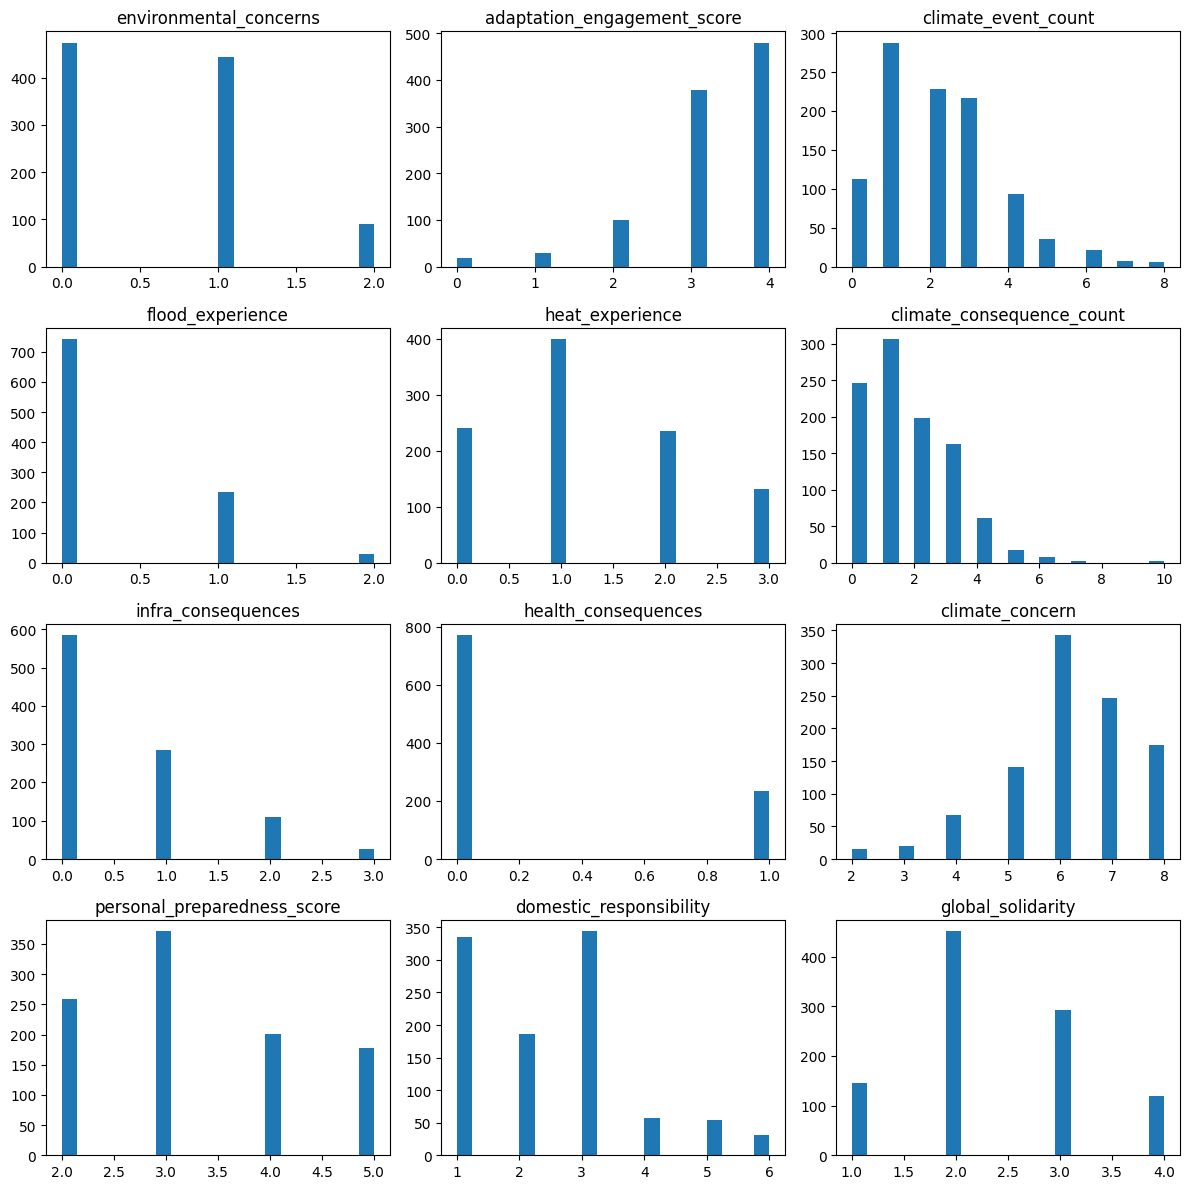

In [162]:
# Plot
n_cols = 3
n_rows = int(np.ceil(len(CLUSTER_FEATURES) / n_cols))
plt.figure(figsize=(4*n_cols, 3*n_rows))
for i, col in enumerate(CLUSTER_FEATURES, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(cluster_df[col], bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

**Results**
None of the numeric features are normal-distributed but this is not a problem as normality is not required for clustering. What is needed is enough variation and comparable as distance-based algorithms (K-means, Ward’s) will give more weight to whichever feature has the largest raw spread - even if substantively it’s not more important. 

I will try out different scalers:
>- StandardScaler (z-score) → centers features to mean 0, variance 1.
Good default for clustering.

>- MinMaxScaler (0–1 range) → rescales all features between 0 and 1.
Useful for bounded features, e.g. for interpretability or plotting.

>- RobustScaler → uses median & IQR, less sensitive to outliers.
Handy when  distributions are skewed.

**Redundancy Check (Correlation Matrix)**

**Goal:** Detect highly correlated features that may duplicate information.  
**Action:** Consider consolidating or dropping one of a highly correlated pair if it harms interpretability.

,environmental_concerns,adaptation_engagement_score,climate_event_count,flood_experience,heat_experience,climate_consequence_count,infra_consequences,health_consequences,climate_concern,personal_preparedness_score,domestic_responsibility,global_solidarity
environmental_concerns,1.000000,0.225681,0.084070,0.002120,0.141517,0.024834,0.018885,0.049648,0.192695,-0.078008,-0.097154,-0.203443
adaptation_engagement_score,0.225681,1.000000,0.154175,0.061210,0.171918,0.113666,0.090645,0.085143,0.375864,-0.132312,-0.180057,-0.187115
climate_event_count,0.084070,0.154175,1.000000,0.571231,0.766269,0.486227,0.355487,0.206947,0.319125,-0.079776,-0.099084,-0.126604
flood_experience,0.002120,0.061210,0.571231,1.000000,0.152367,0.277026,0.194125,0.073696,0.117484,-0.062131,0.011381,-0.127493
heat_experience,0.141517,0.171918,0.766269,0.152367,1.000000,0.375037,0.257450,0.240345,0.288671,-0.039247,-0.116792,-0.122152
climate_consequence_count,0.024834,0.113666,0.486227,0.277026,0.375037,1.000000,0.712450,0.403469,0.294053,-0.156605,-0.002601,-0.180907
infra_consequences,0.018885,0.090645,0.355487,0.194125,0.257450,0.712450,1.000000,0.127517,0.157787,-0.106079,0.020484,-0.090295
health_consequences,0.049648,0.085143,0.206947,0.073696,0.240345,0.403469,0.127517,1.000000,0.154094,-0.052714,0.021937,-0.119239
climate_concern,0.192695,0.375864,0.319125,0.117484,0.288671,0.294053,0.157787,0.154094,1.000000,-0.160008,-0.124033,-0.333645
personal_preparedness_score,-0.078008,-0.132312,-0.079776,-0.062131,-0.039247,-0.156605,-0.106079,-0.052714,-0.160008,1.000000,0.093709,0.249035


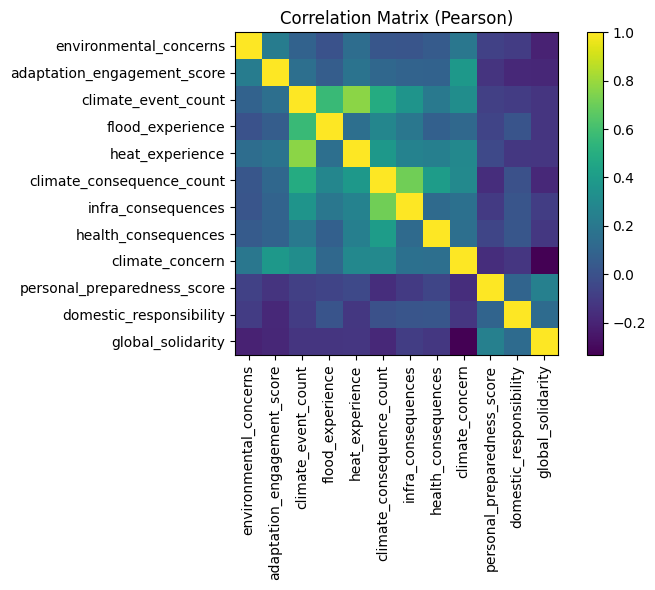

In [163]:
corr = cluster_df.corr(numeric_only=True)
display(corr)
# Heatmap (Matplotlib only)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr.values, interpolation='nearest')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)
fig.colorbar(cax)
ax.set_title("Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()

**Results**

In the correlation analysis, two pairs showed strong relationships:  

- `heat_experience` with `climate_event_count` (r ≈ 0.76)  
- `infra_consequences` with `climate_consequence_count` (r ≈ 0.71)  

These overlaps are expected because the component variables feed into the aggregated totals.  
Rather than automatically removing features, the strategy is:  

- **Keep both aggregate and component measures in initial experiments** to see whether they drive distinct clustering patterns.  
- **Compare cluster solutions** with and without aggregates using internal validity scores (e.g., silhouette, Davies–Bouldin) and interpretability.  
- **Prioritize interpretability over pure metrics**:  
  - If aggregates blur meaningful distinctions (e.g., flood vs heat experiences), drop them.  
  - If aggregates yield simpler, stable clusters that stakeholders can understand, keep them and remove the components.  

This approach balances statistical redundancy with the need for meaningful segmentation, ensuring clusters remain both technically sound and communicable to non-technical audiences.

**Handling Political Preference Missingess**

- **Clustering input**: Political preference will **not** be included in the clustering algorithm.  
  - Reason: the goal is to segment based on **climate awareness and engagement patterns**, not demographics or ideology directly.  
  - Including political leaning could force clusters to form around party lines, obscuring latent climate mindsets.  

- **Post-hoc profiling**: Political preference will instead be used to **interpret clusters after they are formed**.  
  - Example: once clusters are defined (e.g., *Concerned but Passive*, *Skeptical/Disengaged*), we will examine how political affiliation is distributed within each.  
  - This allows us to see whether climate attitudes cut across political boundaries or align with them.  

- **Missing values**:  
  - The survey already encodes `11 = Not declared`.  
  - True missing values (≈4%) will be recoded as `12 = Missing` to keep them analytically distinct.  
  - For reporting, categories 11 and 12 may be combined into a single “No response” group if clarity is needed.  

**Summary**: Political preference remains outside the clustering process but plays a key role in contextualizing and explaining cluster membership, ensuring insights remain both methodologically sound and policy-relevant.

In [164]:
# Check political preference missingness (with percentage)
missing_count = desc_df["political_preference"].isnull().sum() 
percentage_missing = (missing_count / len(desc_df)) * 100
print(f"Missing values in 'political_preference': {missing_count} ({percentage_missing:.2f}%)")

# Recode missing as 12 ( = 'Missing')
desc_df["political_preference"] = desc_df["political_preference"].fillna(12)

#Check value counts again
print(desc_df["political_preference"].value_counts(dropna=False))  

Missing values in 'political_preference': 42 (4.17%)
political_preference
5.0     184
6.0     122
8.0     103
3.0     101
7.0      84
4.0      78
11.0     71
2.0      60
1.0      56
9.0      54
10.0     53
12.0     42
Name: count, dtype: int64


**Note**
I have tried to delete the 42 data points where `political_preference` is missing but it made cluster tendency worse and since I am not using it for clustering I decided to keep those values. 

**Cluster Tendency (Hopkins Statistic)**

**Goal:** Test whether the data likely contains cluster structure.  
**Interpretation:** Values **< 0.5** suggest non-random, clusterable structure; values near **0.5** indicate more randomness.

In [165]:
def hopkins_statistic(X_numeric, sample_ratio=0.1, random_state=42):
    """
    Compute the Hopkins statistic for cluster tendency.
    X_numeric: numpy array (n_samples, n_features), scaled recommended.
    sample_ratio: fraction of samples to draw for the test.
    """
    rng = np.random.default_rng(random_state)
    n = X_numeric.shape[0]
    m = max(1, floor(sample_ratio * n))

    # Fit NN model to real data
    nbrs = NearestNeighbors(n_neighbors=2).fit(X_numeric)

    # Sample m real points
    idx = rng.choice(n, size=m, replace=False)
    X_sample = X_numeric[idx]

    # Uniform sample in the hyper-rectangle of X_numeric
    mins = X_numeric.min(axis=0)
    maxs = X_numeric.max(axis=0)
    U = rng.uniform(mins, maxs, size=(m, X_numeric.shape[1]))

    # Distances to nearest neighbor (excluding self for X_sample)
    d_real, _ = nbrs.kneighbors(X_sample, n_neighbors=2, return_distance=True)
    w = d_real[:, 1].sum()

    # For U, nearest neighbor distance to the real data
    d_unif, _ = nbrs.kneighbors(U, n_neighbors=1, return_distance=True)
    u = d_unif[:, 0].sum()

    H = u / (u + w)
    return H

# Scale before Hopkins
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

H = hopkins_statistic(X_scaled, sample_ratio=HOPKINS_SAMPLE_RATIO, random_state=42)
print(f"Hopkins statistic: {H:.3f}  ( <0.5 suggests clusterable structure )")

Hopkins statistic: 0.690  ( <0.5 suggests clusterable structure )


**Results**

That result is telling you something important:

- **0.690** (all 20 features)  
- **0.700** (I have tried to drop correlated features from the 2 highest correlated pairs gave you the Python snippet to drop `heat_experience` and `climate_consequence_count` but it got worse)  

Both are well above 0.5, which means: your data looks closer to random scatter than to something with natural, tight clusters.

**How to interpret this**

- Hopkins isn’t a death sentence — it’s a heuristic.  
- High values (>0.6) mean the structure isn’t super obvious to distance-based clustering.  
- With survey data (Likert, composites), this is common: opinions grade smoothly rather than falling into sharp clumps.  

**Implication:**  
Clusters may exist, but they’ll be **fuzzy and overlapping**, not cleanly separated.  
Algorithms like **Gaussian Mixture Models (GMM)** (soft assignments) may fit better than strict partitioning like *K-means*.  

Interpretability matters more than silhouette scores — you’ll need to argue for the **meaningfulness of profiles** rather than “perfect separation.”

**Next moves you can try**

**1. Dimensionality reduction**  
- Run PCA or factor analysis on the composites.  
- The main axes may reveal latent “concern vs. disengagement” dimensions that Hopkins on raw features misses.  

**2. Subset features**  
- Not all 12 composites may be helpful.  
- Try clustering on the “attitudinal core” (*concern, preparedness, solidarity, responsibility*).  
- Keep event/experience variables for interpretation.  

**3. Soft clustering (GMM)**  
- If clusters overlap, a probabilistic method makes more sense.  
- Example interpretation:  
  > “This citizen has a 70% chance of being *Concerned but Passive*, 30% *Skeptical*.”  

**4. Validate with interpretability**  
- Focus less on separation metrics, more on whether the clusters produce meaningful, actionable insights.  

**Actionable Suggestions**

This cell inspects the results and prints concise guidance:
- Features with **low CV** (weak signal)
- Features with **very high CV** (consider transform)
- **Highly correlated** pairs (|r| ≥ threshold)
- **Hopkins** interpretation with next steps

In [166]:
tips = []

# CV flags
low_cv_features = variability.index[variability["cv"] < LOW_CV].tolist()
high_cv_features = variability.index[variability["cv"] > HIGH_CV].tolist()

if low_cv_features:
    tips.append(f"- Consider dropping or regrouping low-variability features: {low_cv_features}")
else:
    tips.append("- No low-variability features flagged.")

if high_cv_features:
    tips.append(f"- Consider transforming (e.g., log1p) or trimming outliers for high-variability features: {high_cv_features}")
else:
    tips.append("- No high-variability features flagged.")

# High correlation pairs
high_corr_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        if abs(r) >= HIGH_CORR:
            high_corr_pairs.append((cols[i], cols[j], float(r)))

if high_corr_pairs:
    pair_str = "; ".join([f"{a} ~ {b} (r={r:.2f})" for a, b, r in high_corr_pairs])
    tips.append(f"- Highly correlated pairs (consider consolidating one of each pair): {pair_str}")
else:
    tips.append("- No highly correlated pairs flagged at the current threshold.")

# Hopkins interpretation
if H < 0.45:
    tips.append("- Hopkins suggests **good** cluster tendency (< 0.45). Proceed to clustering.")
elif 0.45 <= H <= 0.55:
    tips.append("- Hopkins suggests **borderline** structure (~0.5). Revisit features, scaling, or sample composition.")
else:
    tips.append("- Hopkins suggests **weak** cluster tendency (> 0.55). Reassess feature set and consider dimensionality reduction.")

print("=== Actionable Suggestions ===")
print("\n".join(tips))


=== Actionable Suggestions ===
- No low-variability features flagged.
- No high-variability features flagged.
- No highly correlated pairs flagged at the current threshold.
- Hopkins suggests **weak** cluster tendency (> 0.55). Reassess feature set and consider dimensionality reduction.


**Next Steps**

- **Scaling**: Standardize inputs before clustering (already done for Hopkins).
- **Dimensionality**: If redundancy is high, consolidate features or try PCA (for visualization/validation).
- **Algorithm short-list** (given your data):
  - K-means / K-medoids (centroid or medoid profiles, interpretable),
  - Hierarchical (Ward’s) for nested structure exploration,
  - GMM for overlapping profiles (soft assignment probabilities).
- **Use demographics post-hoc** to label/understand clusters (avoid letting them drive cluster formation).
- **Document** changes in your README/charter so stakeholders see how data decisions support impact.

When variability is adequate, redundancy managed, and Hopkins < 0.5, you’re safe to move into clustering experiments and model selection.

In [167]:
# Save cluster_df for clustering step
utils.save_dataset(cluster_df, "04_climate_dataset_forClustering_unscaled.xlsx", "interim")

# Save desc_df for descriptive stats later
utils.save_dataset(desc_df, "04_climate_dataset_descriptive_features.xlsx", "interim")

File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\interim\04_climate_dataset_forClustering_unscaled.xlsx
File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\interim\04_climate_dataset_descriptive_features.xlsx


<div class="alert alert-block alert-info">
<b>Next Notebook - Data ...
</div>